In [1]:
import numpy as np
import pandas as pd
from folium import plugins
import datetime
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import re

from geopy.geocoders import Photon

geolocator = Photon(user_agent="measurements")

# Preprocessing

In [2]:
raw_weather_data = pd.read_csv("weather_NY_2010_2018Nov.csv")
raw_weather_data.head(10)

,USAF,WBAN,StationName,State,Latitude,Longitude,MeanTemp,MinTemp,MaxTemp,DewPoint,Percipitation,WindSpeed,MaxSustainedWind,Gust,Rain,SnowDepth,SnowIce,Year,Month,Day
0,726228,94740,ADIRONDACK REGIONAL ARPT,NY,44.385,-74.207,27.6,24.8,30.9,25.0,0.07,1.3,6.0,NaN,0,NaN,1,2010,1,1
1,726228,94740,ADIRONDACK REGIONAL ARPT,NY,44.385,-74.207,-3.2,-20.9,17.1,-9.6,0.00,3.3,9.9,NaN,0,NaN,1,2010,1,10
2,726228,94740,ADIRONDACK REGIONAL ARPT,NY,44.385,-74.207,20.9,17.1,24.1,15.1,0.00,6.8,12.0,19.0,0,NaN,1,2010,1,11
3,726228,94740,ADIRONDACK REGIONAL ARPT,NY,44.385,-74.207,13.8,5.0,19.9,8.5,NaN,4.4,8.0,15.9,0,NaN,1,2010,1,12
4,726228,94740,ADIRONDACK REGIONAL ARPT,NY,44.385,-74.207,6.3,-8.0,19.0,1.9,0.00,3.3,5.1,NaN,0,NaN,1,2010,1,13
5,726228,94740,ADIRONDACK REGIONAL ARPT,NY,44.385,-74.207,23.5,19.4,28.4,20.9,0.01,4.7,15.9,17.1,0,NaN,0,2010,1,14
6,726228,94740,ADIRONDACK REGIONAL ARPT,NY,44.385,-74.207,32.7,28.4,35.6,29.5,0.00,6.1,9.9,20.0,1,NaN,1,2010,1,15
7,726228,94740,ADIRONDACK REGIONAL ARPT,NY,44.385,-74.207,29.9,28.4,30.9,26.4,0.02,8.3,15.0,22.9,0,NaN,0,2010,1,16
8,726228,94740,ADIRONDACK REGIONAL ARPT,NY,44.385,-74.207,30.1,21.9,37.0,27.0,0.00,2.0,8.0,NaN,0,NaN,0,2010,1,17
9,726228,94740,ADIRONDACK REGIONAL ARPT,NY,44.385,-74.207,31.9,28.9,36.0,29.7,0.00,2.0,8.9,NaN,0,NaN,1,2010,1,18


In [3]:
# preprocessing
# use lagtitude and longtitude to get location
raw_weather_data = raw_weather_data[(raw_weather_data["Year"] >= 2016) & (raw_weather_data["Year"] <= 2018)]
weather_df_1 = raw_weather_data[["Latitude", "Longitude", "StationName"]].drop_duplicates().reset_index()
weather_df_1["city"] = weather_df_1.apply(lambda x: geolocator.reverse([x.Latitude, x.Longitude])[0], axis=1)

In [4]:
## use lagtitude and longtitude to get location and filter data only in new york city
weather_df_1["ny1"] = weather_df_1["city"].replace("New York", "NY", regex=True)
weather_df_1["count"] = weather_df_1["ny1"].apply(lambda x: sum(1 for _ in re.finditer(r"\b%s\b" % re.escape("NY"), x)))
ny_station = {
    "CENTRAL PARK": "Manhattan",
    "JOHN F KENNEDY INTERNATIONAL AIRPORT": "Queens",
    "LA GUARDIA AIRPORT": "Queens",
    "KINGS POINT": "Queens",
    "THE BATTERY": "Manhattan",
    "PORT AUTH DOWNTN MANHATTAN WALL ST HEL": "Manhattan",
    "BERGEN POINT": "StatenIsland",
}

weather_df_2 = raw_weather_data.copy()
weather_df_2 = weather_df_2[weather_df_2["StationName"].isin(ny_station.keys())].reset_index(drop=True)
weather_df_2["Borough"] = weather_df_2["StationName"].apply(lambda x: ny_station.get(x))

In [5]:
# select features of interests
weather_df_3 = weather_df_2.copy()
weather_df_3["Date"] = weather_df_3.apply(lambda x: datetime.datetime(x.Year, x.Month, x.Day), axis=1)
weather_df_3.drop(["USAF", "WBAN", "Latitude", "Longitude", "Year", "Month", "Day"], axis=1, inplace=True)
weather_df_3 = weather_df_3.sort_values(["StationName", "Date"]).reset_index(drop=True)

In [6]:
weather_df_3.describe()

,MeanTemp,MinTemp,MaxTemp,DewPoint,Percipitation,WindSpeed,MaxSustainedWind,Gust,Rain,SnowDepth,SnowIce
count,6417.000000,6416.000000,6417.000000,3922.000000,6398.000000,6286.00000,4612.000000,2639.000000,6417.00000,231.000000,6417.000000
mean,56.036777,49.165617,64.761742,44.402779,0.161966,5.66699,14.292476,24.966844,0.22830,3.731602,0.034596
std,16.996723,16.805076,17.608469,18.957469,2.809265,4.80601,5.553447,7.811051,0.41977,4.458523,0.182767
min,6.900000,-0.900000,15.300000,-16.300000,0.000000,0.00000,2.900000,14.000000,0.00000,1.200000,0.000000
25%,42.300000,36.075000,50.200000,29.625000,0.000000,0.00000,9.900000,19.000000,0.00000,1.200000,0.000000
50%,55.500000,48.200000,64.900000,46.300000,0.000000,5.40000,14.000000,22.900000,0.00000,2.000000,0.000000
75%,71.800000,64.900000,80.400000,60.500000,0.020000,8.70000,18.100000,28.900000,0.00000,5.100000,0.000000
max,90.900000,82.400000,100.900000,77.000000,99.990000,26.70000,42.000000,59.100000,1.00000,27.200000,1.000000


# Data Analysis and Visualization

In [7]:
def plot_hist(data, col, dpi=100, figsize=(5, 5), log=False):
    fig, axs = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (0.15, 0.85)}, figsize=figsize, dpi=dpi)
    if log == True:
        hist_data = np.log(data[col])
        col_name = "log(" + col + ")"
    else:
        hist_data = data[col]
        col_name = col
    ax_box = sns.boxplot(x=hist_data, ax=axs[0])
    sns.histplot(hist_data, bins=200, kde=True, ax=axs[1])
    ax_box.set(xlabel="")
    axs[0].set_title(f"Distribution of {col_name}")
    plt.show()

In [8]:
def plot_correlation(data, figsize=(10, 10), annot_size=8, fontsize=7, name="corr", save=False):
    corrmat = data.corr()
    hmf, hmax = plt.subplots(figsize=figsize)
    hmax = sns.heatmap(corrmat, vmax=1, vmin=-1, annot=True, square=True, cmap="RdBu", fmt=".2f", annot_kws={"size": annot_size})
    hmax.set_xticklabels(hmax.get_xmajorticklabels(), fontsize=fontsize)
    hmax.set_yticklabels(hmax.get_ymajorticklabels(), fontsize=fontsize)
    plt.title("Correlation of Adjusted Variables", fontsize=25, y=1.05)
    plt.xticks(rotation=45)
    if save == True:
        plt.savefig(name + ".png", bbox_inches="tight")
    plt.show()

### Distribution of MeanTemp Feature

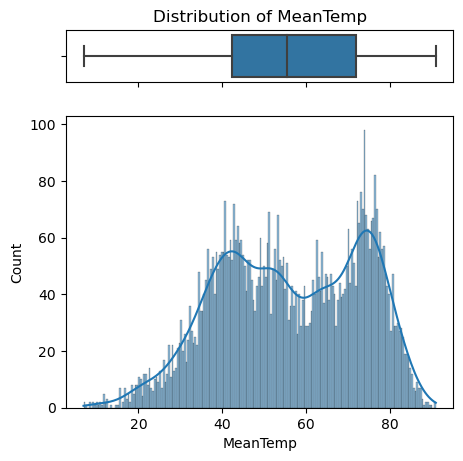

In [9]:
plot_hist(weather_df_3, "MeanTemp")

Text(0.5, 1.0, 'Mean Temperatures for Different Weather Stations')

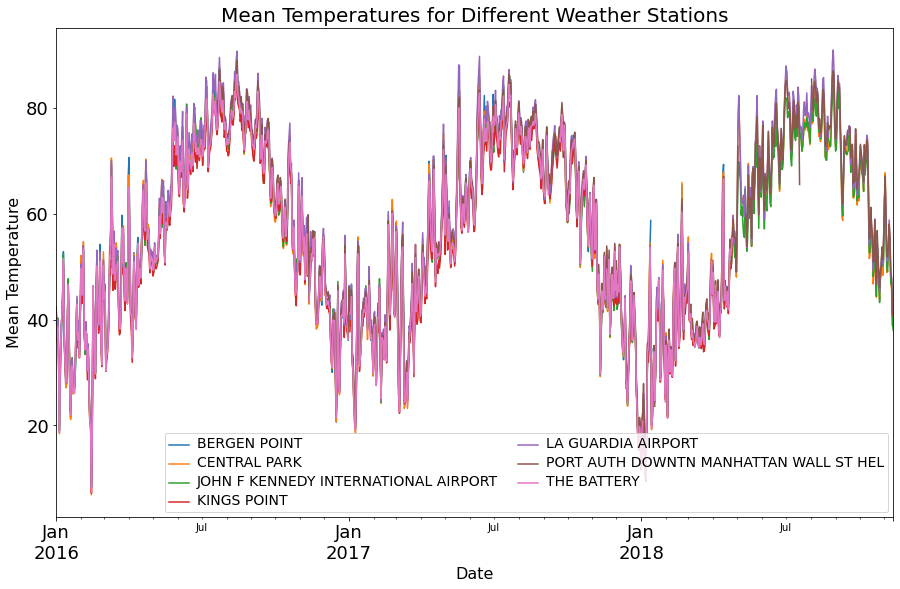

In [10]:
df_pivot = weather_df_3[["MeanTemp", "Date", "StationName"]].pivot(columns="Date", values="MeanTemp", index="StationName").T
fig, ax = plt.subplots(figsize=(15, 9))
df_pivot.plot(ax=ax)
ax.legend(ncol=2)
plt.setp(ax.get_legend().get_texts(), fontsize="14")  # for legend text
plt.setp(ax.get_legend().get_title(), fontsize="14")
plt.tick_params(axis="both", labelsize=18)
ax.set_xlabel("Date", fontsize=16)
ax.set_ylabel("Mean Temperature", fontsize=16)
ax.set_title("Mean Temperatures for Different Weather Stations", fontsize=20)

### Distribution of WindSpeed Feature

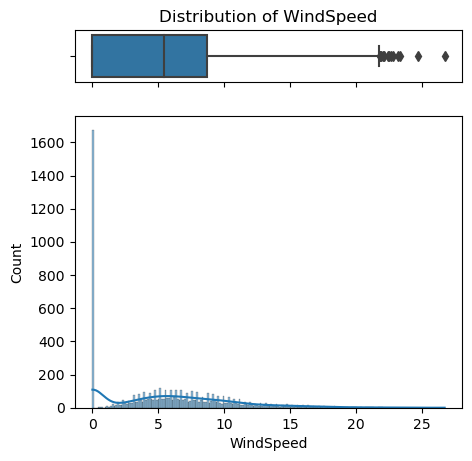

In [11]:
plot_hist(weather_df_3, "WindSpeed")

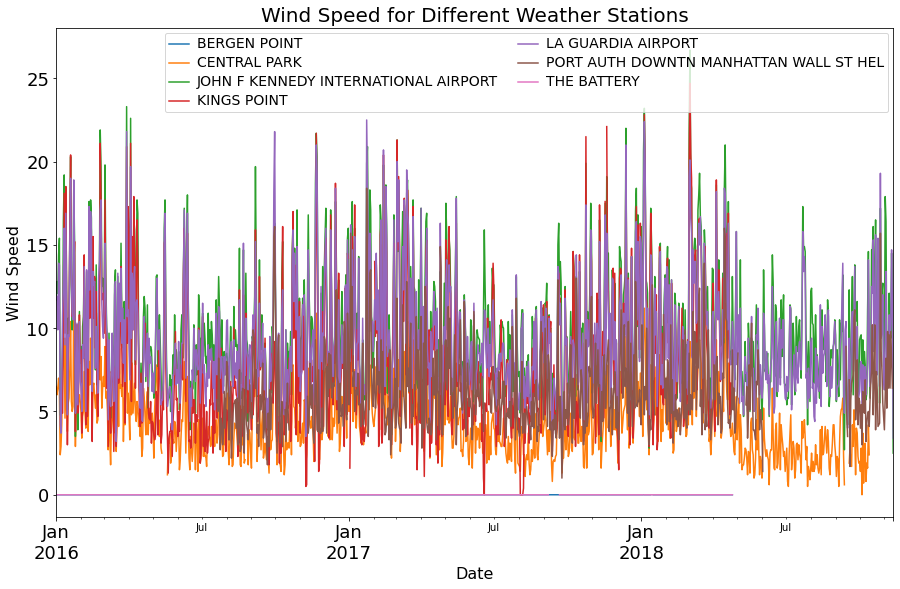

In [12]:
df_pivot = weather_df_3[["WindSpeed", "Date", "StationName"]].pivot(columns="Date", values="WindSpeed", index="StationName").T
fig, ax = plt.subplots(figsize=(15, 9))
df_pivot.plot(ax=ax)
ax.legend(ncol=2)
plt.setp(ax.get_legend().get_texts(), fontsize="14")  # for legend text
plt.setp(ax.get_legend().get_title(), fontsize="14")
plt.tick_params(axis="both", labelsize=18)
ax.set_xlabel("Date", fontsize=16)
ax.set_ylabel("Wind Speed", fontsize=16)
ax.set_title("Wind Speed for Different Weather Stations", fontsize=20)
plt.show()

### Correlation Plot of All Features

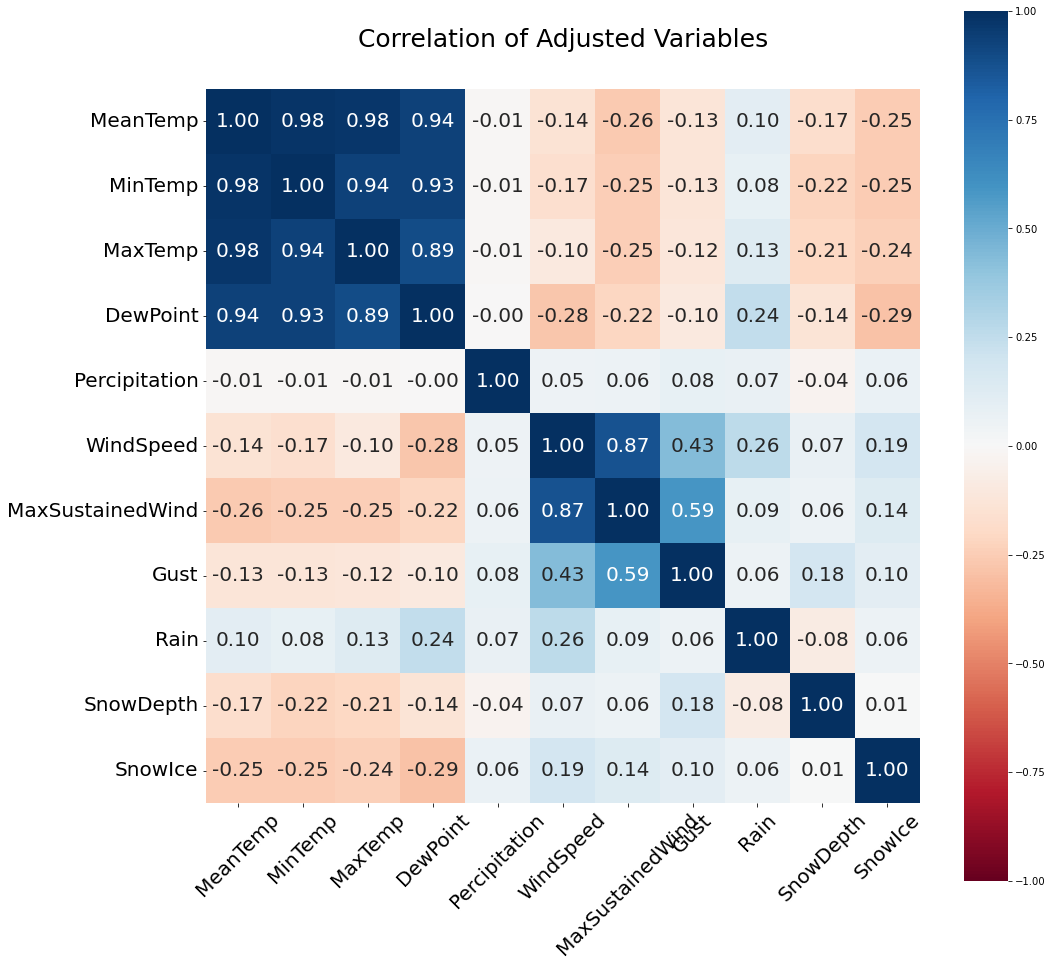

In [13]:
plot_correlation(weather_df_3, figsize=(16, 16), annot_size=20, fontsize=20)

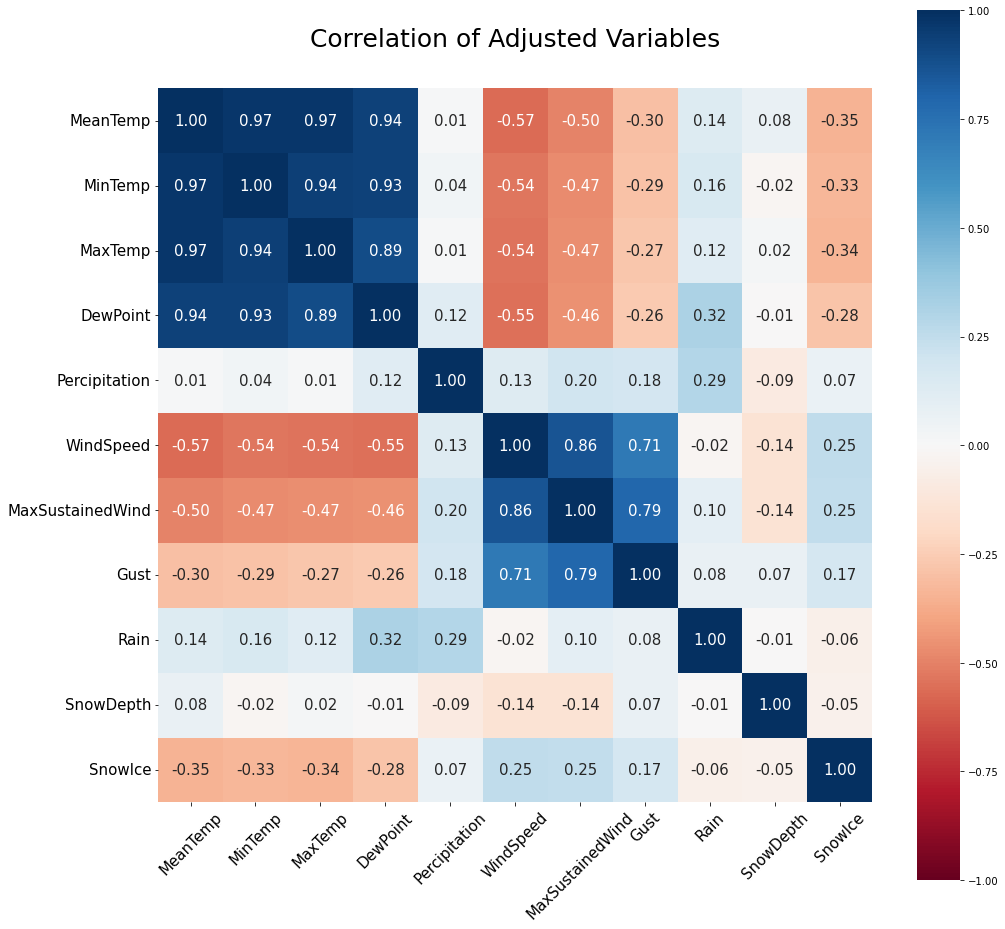

In [14]:
plot_correlation(weather_df_3[weather_df_3["StationName"] == "CENTRAL PARK"], figsize=(16, 16), annot_size=15, fontsize=15)

# Imputation and Feature Selection

In [15]:
weather_df_3.describe()

,MeanTemp,MinTemp,MaxTemp,DewPoint,Percipitation,WindSpeed,MaxSustainedWind,Gust,Rain,SnowDepth,SnowIce
count,6417.000000,6416.000000,6417.000000,3922.000000,6398.000000,6286.00000,4612.000000,2639.000000,6417.00000,231.000000,6417.000000
mean,56.036777,49.165617,64.761742,44.402779,0.161966,5.66699,14.292476,24.966844,0.22830,3.731602,0.034596
std,16.996723,16.805076,17.608469,18.957469,2.809265,4.80601,5.553447,7.811051,0.41977,4.458523,0.182767
min,6.900000,-0.900000,15.300000,-16.300000,0.000000,0.00000,2.900000,14.000000,0.00000,1.200000,0.000000
25%,42.300000,36.075000,50.200000,29.625000,0.000000,0.00000,9.900000,19.000000,0.00000,1.200000,0.000000
50%,55.500000,48.200000,64.900000,46.300000,0.000000,5.40000,14.000000,22.900000,0.00000,2.000000,0.000000
75%,71.800000,64.900000,80.400000,60.500000,0.020000,8.70000,18.100000,28.900000,0.00000,5.100000,0.000000
max,90.900000,82.400000,100.900000,77.000000,99.990000,26.70000,42.000000,59.100000,1.00000,27.200000,1.000000


In [16]:
# Imputation using mean of previous and next available value
weather_df_pos = weather_df_3.copy()
# Drop features with duplicate information
weather_df_pos.drop(["MinTemp", "MaxTemp", "DewPoint", "MaxSustainedWind", "Gust"], axis=1, inplace=True)
weather_df_pos["Percipitation"] = weather_df_3["Percipitation"].interpolate()
weather_df_pos["WindSpeed"] = weather_df_3["WindSpeed"].interpolate()
weather_df_pos["SnowDepth"] = weather_df_3["SnowDepth"].fillna(method="bfill").fillna(method="ffill")
weather_df_pos["SnowDepth"] = weather_df_pos.apply(lambda x: 0 if x["SnowIce"] == 0 else x["SnowDepth"], axis=1)

In [17]:
def plot_correlation(data, figsize=(10, 10), annot_size=8, fontsize=7, name="corr", save=False):
    corrmat = data.corr()
    hmf, hmax = plt.subplots(figsize=figsize)
    hmax = sns.heatmap(corrmat, vmax=1, vmin=-1, annot=True, square=True, cmap="RdBu", fmt=".2f", annot_kws={"size": annot_size})
    hmax.set_xticklabels(hmax.get_xmajorticklabels(), fontsize=fontsize)
    hmax.set_yticklabels(hmax.get_ymajorticklabels(), fontsize=fontsize)
    plt.title("Correlation of Adjusted Variables", fontsize=25, y=1.05)
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    if save == True:
        plt.savefig(name + ".png", bbox_inches="tight")
    plt.show()

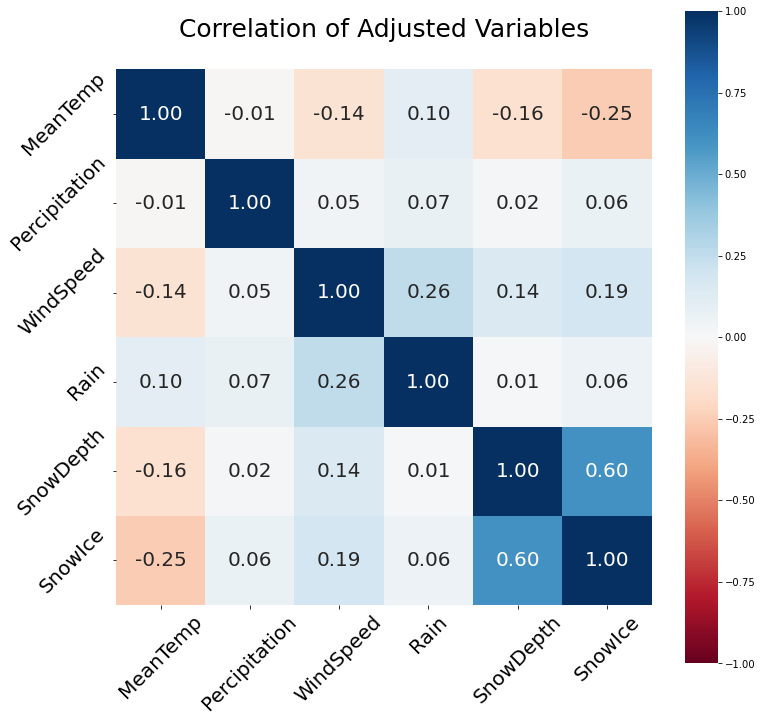

In [18]:
plot_correlation(weather_df_pos, figsize=(12, 12), annot_size=20, fontsize=20)

In [19]:
# after imputation and processing
weather_df_pos.describe()

,MeanTemp,Percipitation,WindSpeed,Rain,SnowDepth,SnowIce
count,6417.000000,6417.000000,6417.000000,6417.00000,6417.000000,6417.000000
mean,56.036777,0.161637,5.659787,0.22830,0.103506,0.034596
std,16.996723,2.805112,4.770512,0.41977,0.907304,0.182767
min,6.900000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,42.300000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,55.500000,0.000000,5.400000,0.00000,0.000000,0.000000
75%,71.800000,0.020000,8.700000,0.00000,0.000000,0.000000
max,90.900000,99.990000,26.700000,1.00000,27.200000,1.000000


In [20]:
weather_df_pos.to_csv("weather_processed.csv", index=False)

In [21]:
len(pd.read_csv("weather_NY_2010_2018Nov.csv"))

160775